# Compute time series from the ECCOv4r4 runs

In [217]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pych

In [2]:
uvel = xr.open_dataarray('../ncfiles/eccov4r4_uvel_short.nc').sortby(['time','depth','lon'])

## 1. Core speed = max velocity over depth

In [3]:
uMax = uvel.max('depth')
uMax.name = 'Core Speed'
uMax.attrs['description'] = 'Maximum speed at time interval and longitude'
uMax.attrs['units'] = 'm/s'

## 2. Core depth: depth of max speed

In [4]:
depthMax = xr.zeros_like(uMax)
depthMax.name = 'Core Depth'
depthMax.attrs['description'] = 'Depth of maximum speed at time interval and longitude'
depthMax.attrs['units'] = 'm'

In [5]:
with xr.set_options(keep_attrs=True):
    depthtime = uvel.depth.broadcast_like(uvel.time)
    for lon in uvel.lon.values:
        ind = np.argmax(uvel.sel(lon=lon),axis=1)
        depthMax.loc[{'lon':lon}] = depthtime[:,ind]

## 3. Core thickness: distance in depth over which velocity is positive

Here, linearly interpolate to approximate the zero crossing

### Example indices for edge cases:
- time index 50: lower portion does not cross zero, in this case, take depth of minimum velocity
- time index 60* 24: is a good case
- time index 80 * 24: lower half goes negative then positive
- time index 25 * 24: upper half never goes positive

In [196]:
def get_bounding_depths(uprof,coredepth):
    
    uvelUpperHalf = get_crossing_depth(uprof.where(uprof.depth<coredepth,drop=True),True)
    uvelLowerHalf = get_crossing_depth(uprof.where(uprof.depth>coredepth,drop=True),False)
    return uvelUpperHalf,uvelLowerHalf

In [197]:
def get_crossing_depth(half_profile,isUpper):
    half_index = np.argsort(np.abs(half_profile))
    posInd = half_profile>0
    negInd = half_profile<0
    myrolls = [-1,1] if isUpper else [1,-1]
    
    # indices where positive and negative values are neighbors
    negSel = posInd.shift({'depth':myrolls[0]},False) & negInd
    posSel = negInd.shift({'depth':myrolls[1]},False) & posInd
    
    
    uNeg = half_profile.where(negSel)
    uPos = half_profile.where(posSel)
    dNeg = half_profile.depth.where(negSel)
    dPos = half_profile.depth.where(posSel)
    
    deltaD = (dPos - dNeg.shift({'depth':myrolls[1]},np.NAN)).sum('depth')
    deltaU = np.abs(half_profile.where(negSel | posSel)).sum('depth')
    
    dZero = dNeg - deltaD * (uNeg/deltaU) 
    depth_min =half_profile.depth.where(half_profile==half_profile.min('depth')) 
    result = xr.where((negSel | posSel).any('depth'),dZero,depth_min)
    return result.sum('depth')

In [198]:
lon = -140
tind = 50
uu = uvel.sel(lon=lon)
coredepth = depthMax.sel(lon=lon)

In [199]:
up,lo = get_bounding_depths(uvel,depthMax)

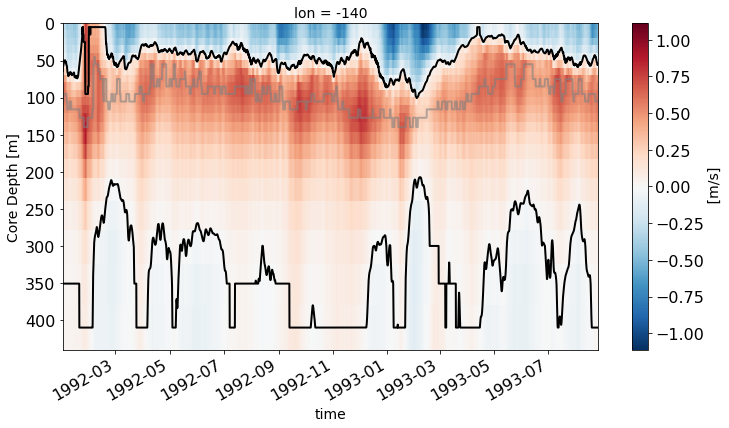

In [202]:

fig,ax = plt.subplots(1,1,figsize=(12,6))

uvel.sel(lon=lon).plot(ax=ax,y='depth',yincrease=False)
up.sel(lon=lon).plot(ax=ax,color='black')
lo.sel(lon=lon).plot(ax=ax,color='black')
depthMax.sel(lon=lon).plot(ax=ax,color='gray',alpha=.6)
fig.savefig('../figures/eccov4r4_uvel_hourly_140W.png',bbox_inches='tight',dpi=300)
#ax.set(xlim=['1992-01-25','1992-02-01'])

### Edge cases for upper core depth
- at '1992-01-28T12', neither upper or lower cross zero (all positive). 
    o upper: grab minimum which is *not* the highest depth, but does seem to be intuitively what we would consider to be the upper bound of the "core" 
- at '1992-01-25T12', neither upper or lower cross zero (all positive). 
    o upper: grab minimum which is neither the highest depth, nor is it the first point where the curvature changes, and so it seems less like the "core bounds"

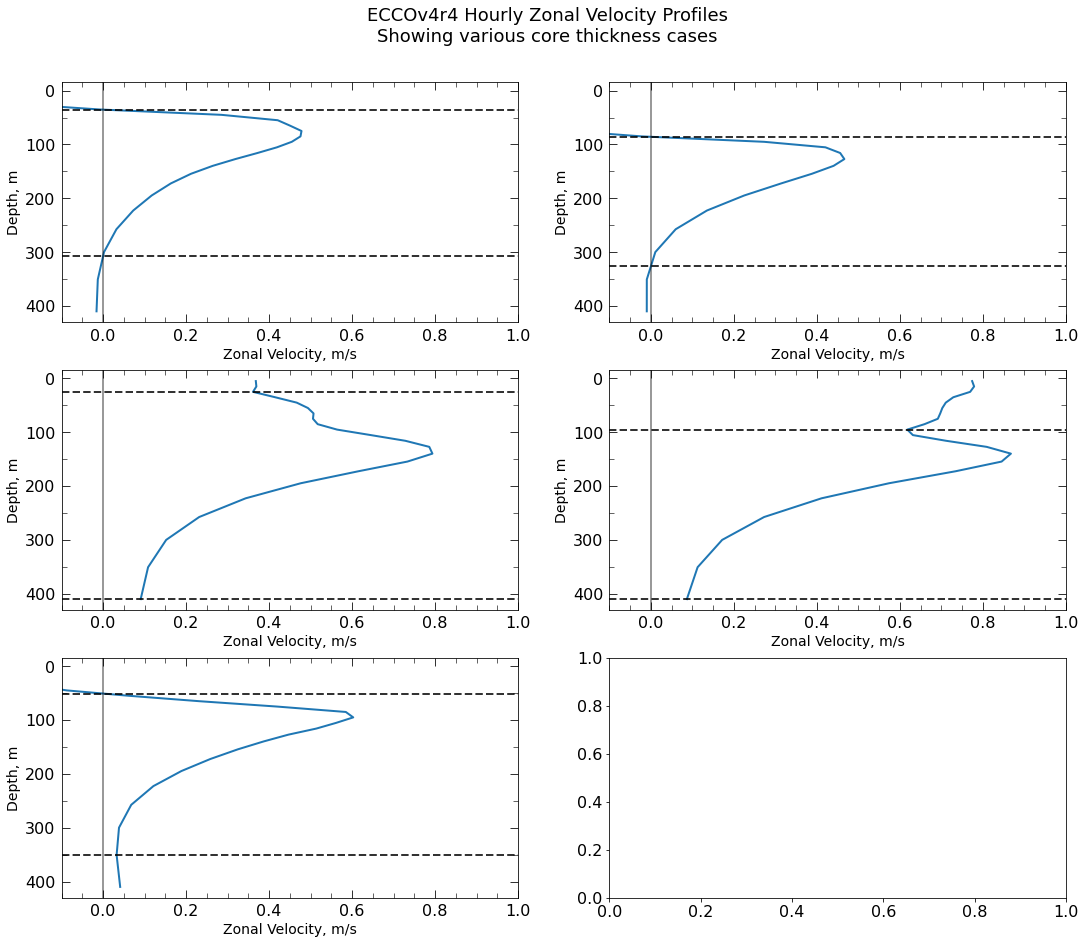

In [232]:
fig,axs = plt.subplots(3,2,figsize=(18,5*3))
times = ['1992-05-01T12','1993-01-01T12','1992-01-25T12','1992-01-28T12','1992-01-03T15']
for tt,ax in zip(times,axs.flatten()):
    uu.sel(time=tt).plot(y='depth',yincrease=False,ax=ax)
    ax.axhline(lo.sel(lon=lon,time=tt),color='black',alpha=.8,linestyle='--')
    ax.axhline(up.sel(lon=lon,time=tt),color='black',alpha=.8,linestyle='--')
    ax.axvline(0,color='black',alpha=.4)
    ax.set(xlim=[-.1,1],title='',ylabel='Depth, m',xlabel='Zonal Velocity, m/s')
    pych.nice_inward_ticks(ax=ax,xminor_skip=.05,yminor_skip=50)
fig.suptitle('ECCOv4r4 Hourly Zonal Velocity Profiles\nShowing various core thickness cases',fontsize=18,y=.95)
fig.savefig('../figures/eccov4r4_uvel_profiles_140W.png',dpi=300,bbox_inches='tight')